In [1]:
'''
A basic plotting code
'''
#most likely comment these out if you aren't running this in Jupyterlab
%load_ext autoreload
%autoreload 2

In [2]:
import dataFile as df #class to open the data file
import matplotlib.pyplot as plt #plotting utility
import numpy as np 
from scipy import signal #used for convolutions
from scipy import optimize #used for fitting
from scipy.ndimage import gaussian_filter1d
from  scipy import stats
import os #used for file operations
import pickle #used for saving temporary results
import time

from multiprocessing import Lock, Process, Queue, current_process #to make things faster
import multiprocessing as mp

#advanced plotting routines
from pylab import rcParams
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from pylab import rcParams

In [3]:
#file to open and plot
filename = '/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/beamOnFolder/2 inch collimation/beam on/2inchCollimationBeamOn_25-30ms/run73437.bin'
datafile = df.dataFile(filename)

In [5]:
#write an algorithm to go through and find the relevant waveforms, do this with the fitting routine
x = np.arange(length)
fitFunc = np.zeros(length)
fitFunc[halfPoint:] = np.exp(-1*x[:halfPoint] / decayrate)
const = np.ones(length)
linear = x[:]/np.max(x)
fitFuncs = np.asarray([fitFunc, const, linear])
fitFuncs = np.transpose(fitFuncs)
pinv = np.linalg.pinv(fitFuncs)


        

NameError: name 'length' is not defined

float64


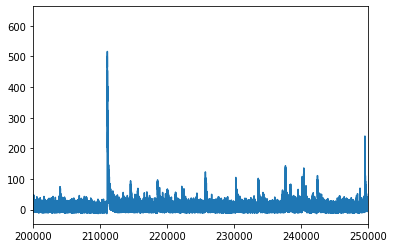

float64


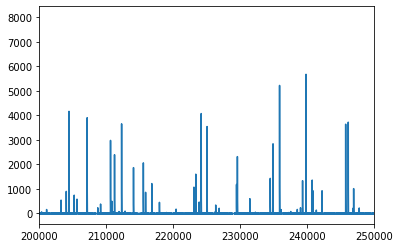

float64


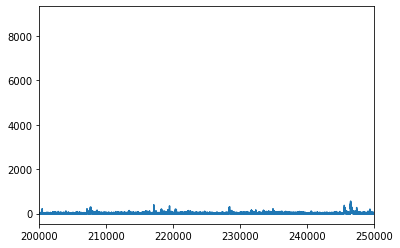

float64


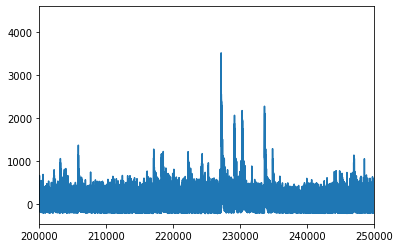

float64


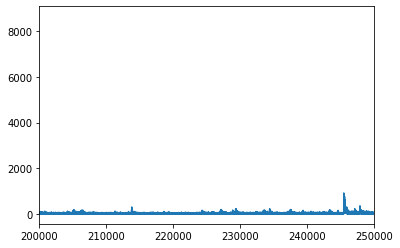

float64


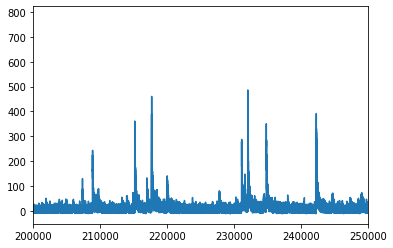

float64


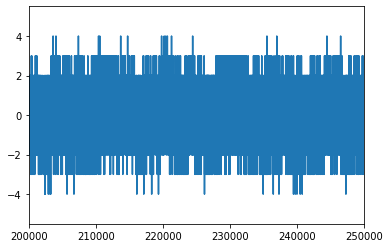

float64


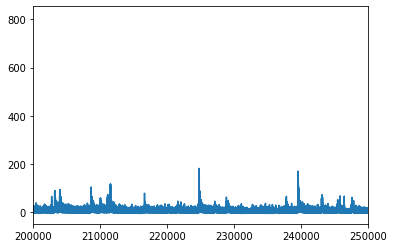

In [11]:
for i in range(8):
    channel = datafile.getPixel(i)
    xlow = 200000
    xhigh = 250000
    wave = channel[2].astype(np.float64)
    hist, bins = np.histogram(wave, np.arange(0, 16384))
    avg = np.argmax(hist)
    print(wave.dtype)
    wave = wave[:] - avg
    plt.plot(wave*-1)
    plt.xlim(xlow, xhigh)
    plt.show()


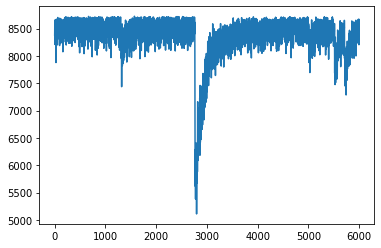

In [23]:
channel = datafile.getPixel(3)
xlow = 202000
xhigh = 208000
wave = channel[0]
wavepiece = wave[xlow:xhigh]
plt.plot(wavepiece)
plt.show()
np.savetxt('sampleWaveform.txt', wavepiece, delimiter = '\n')

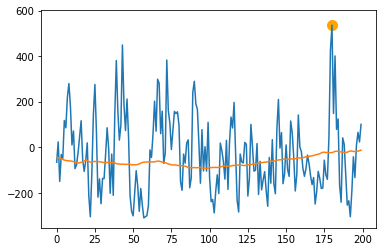

In [27]:
def findPeaks(wave):
    height = 30
    threshold = None
    distance = 500
    prominence = None
    width = None
    wlen = None
    rel_height = None
    plateau_size = None
    peaks, props = signal.find_peaks(wave, height = height, 
                                    threshold = threshold, distance = distance, 
                                    prominence = prominence, width = width,
                                    wlen = wlen, rel_height = rel_height,
                                    plateau_size = plateau_size)
    return peaks

def trapezoidalFilter(wave, rise, top, tau):
    #first define the filter
    filt = np.zeros(rise * 2 + top)
    for i in range(rise):
        filt[i] = i+tau
        filt[i+rise+top] = rise-tau-i
    for i in range(rise, rise+top):
        filt[i]=rise
    scale = 1.0/(rise * tau)
    filt = np.multiply(filt, scale)
    filterLength = rise * 2 + top
    #now apply the filter
    res = signal.fftconvolve(wave, filt, mode='same')
    return res


channel = datafile.getPixel(3)
xlow = 209000
xhigh = 209200
wave = channel[0]
wavepiece = wave[xlow:xhigh]*-1
wavepiece = wavepiece - np.mean(wavepiece[:100])
filtered = gaussian_filter1d(wavepiece, 2, mode='constant')
filtres = trapezoidalFilter(wavepiece, 160, 10, 80)
peakSmoothed = findPeaks(filtres)
peaks = findPeaks(wavepiece)
bins = np.arange(xhigh - xlow)
plt.plot(bins, wavepiece)
plt.scatter(peakSmoothed, filtres[peakSmoothed], c='red', s = 100)
plt.plot(bins, filtres)
plt.scatter(peaks, wavepiece[peaks], c='orange', s= 100)
#plt.xlim(95000, 97500)
plt.show()

0.0016171932220458984


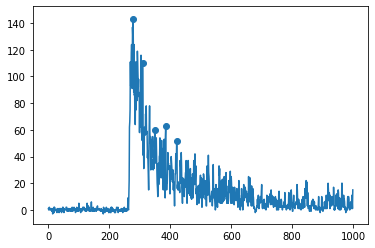

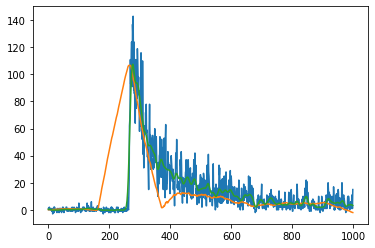

-95.70282738652747 -0.010449012085726263 7.30959278884897


In [91]:
def trapezoidalFilter(wave, rise, top, tau):
    #first define the filter
    filt = np.zeros(rise * 2 + top)
    for i in range(rise):
        filt[i] = i+tau
        filt[i+rise+top] = rise-tau-i
    for i in range(rise, rise+top):
        filt[i]=rise
    scale = 1.0/(rise * tau)
    filt = np.multiply(filt, scale)
    filterLength = rise * 2 + top
    #now apply the filter
    res = signal.fftconvolve(wave, filt, mode='same')
    return res

def baselineShift(wave, window):
    #flip the waveform over
    wave = wave[:] * -1
    #now find the baseline and shift it to 0
    wave = wave[:] - np.mean(wave[:window])
    return wave  

def findPeaks(wave):
    height = 50
    threshold = None
    distance = 30
    prominence = None
    width = None
    wlen = None
    rel_height = None
    plateau_size = None
    peaks, props = signal.find_peaks(wave, height = height, 
                                    threshold = threshold, distance = distance, 
                                    prominence = prominence, width = width,
                                    wlen = wlen, rel_height = rel_height,
                                    plateau_size = plateau_size)
    return peaks

def fitDecay(wave, startbin, stopbin):
    window = wave[startbin:stopbin]
    logwave = np.log(window)
    m,b = np.polyfit(np.arange(startbin, stopbin), logwave, 1)
    return m, b

def energyExtractionPeak(wave, peak, rise, top, threshold):
    #find the average value around the peak
    peakAverage = np.mean(wave[peak-10:peak+10])
    leftpoint = peak - rise - top*2
    if leftpoint < 0:
        leftpoint = 0
    baseline = np.mean(wave[leftpoint: leftpoint+50])
    return peakAverage - baseline

start = time.time()
flipped = baselineShift(channel[0][xlow:xhigh], 50)
filtres = trapezoidalFilter(flipped[:], 100, 10, 100)
peaks = findPeaks(flipped)
stop = time.time()
print(stop-start)


plt.plot(flipped)
plt.scatter(peaks, flipped[peaks])
plt.show()
gaussian = gaussian_filter1d(flipped, 5, mode='constant')

plt.plot(flipped)
plt.plot(filtres)
plt.plot(gaussian)
plt.show()

m, b = fitDecay(flipped, 300, 400)
print(1/m, m, b)

In [116]:
def findPeaks(wave):
    height = None
    threshold = None
    distance = 500
    prominence = 20
    width = 100
    wlen = None
    rel_height = 0.5
    plateau_size = None
    peaks, props = signal.find_peaks(wave, height = height, 
                                    threshold = threshold, distance = distance, 
                                    prominence = prominence, width = width,
                                    wlen = wlen, rel_height = rel_height,
                                    plateau_size = plateau_size)
    return peaks

In [42]:
def baselineShift(wave, window, flip = True):
    #flip the waveform over
    if flip:
        wave = wave[:] * -1
    #now find the baseline and shift it to 0
    wave = wave[:] - np.mean(wave[:window])
    return wave    

def trapezoidalFilter(wave, rise, top, tau):
    #first define the filter
    filt = np.zeros(rise * 2 + top)
    for i in range(rise):
        filt[i] = i+tau
        filt[i+rise+top] = rise-tau-i
    for i in range(rise, rise+top):
        filt[i]=rise
    scale = 1.0/(rise * tau)
    filt = np.multiply(filt, scale)
    filterLength = rise * 2 + top
    #now apply the filter
    res = signal.fftconvolve(wave, filt, mode='same')
    return res

def findPeaks(wave):
    height = None
    threshold = None
    distance = 500
    prominence = 50
    width = 10
    wlen = None
    rel_height = 0.5
    plateau_size = None
    peaks, props = signal.find_peaks(wave, height = height, 
                                    threshold = threshold, distance = distance, 
                                    prominence = prominence, width = width,
                                    wlen = wlen, rel_height = rel_height,
                                    plateau_size = plateau_size)
    return peaks

def getFileNames(fileDir):
    dataFileNames = []
    if os.path.isdir(fileDir):  #if the given path is a directory, find all data files in that directory and analyze them
        tempFileNames = [f for f in os.listdir(fileDir) if os.path.isfile(os.path.join(fileDir, f))] #grab all files that are actually files, not directories
        tempFileNames = [fileDir + fileName for fileName in tempFileNames] #now add the path to the files onto each one
        #only grab the ones that are actually data files and have a .bin extension, otherwise ignore them
        for file in tempFileNames:
                name, extension = os.path.splitext(file)
                if extension == '.bin':
                    dataFileNames.append(file)
    elif os.path.isfile(fileDir): #if it is a file, assume they knew what they were doing and provided a real file  
        dataFileNames = [fileDir]
    dataFileNames.sort()
    return dataFileNames

def getAllFileNames(path, ext='.bin', overwrite = False, outputExtension = '.res'):
    files = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if ext in file:
                if ext == '.bin' and overwrite == False:
                    name, ext = os.path.splitext(os.path.join(r, file))
                    resultFile = name + outputExtension
                    if os.path.isfile(resultFile) == False:#if no result file add it to the list
                        files.append(os.path.join(r, file))
                else:
                    files.append(os.path.join(r, file))
                
    files.sort()
    return files

#this function finds the energy from one peak in the waveform
def energyExtractionPeak(wave, peak, rise, top, threshold):
    #find the average value around the peak
    peakAverage = np.mean(wave[peak-10:peak+10])
    leftpoint = peak - rise - top*2
    if leftpoint < 0:
        leftpoint = 0
    baseline = np.mean(wave[leftpoint: leftpoint+50])
    return peakAverage - baseline

        

#this function finds the energy from multiple peaks by calling the above function
def energyExtractionWave(wave, peaks, rise, top, threshold):
    energies = []
    for peak in peaks:
        energy = energyExtractionPeak(wave, peak, rise, top, threshold)
        energies.append(energy)
    return energies

def perWaveAnalysis(wave):
    enerRise = 500
    enerTop = 100
    enerTau = 110
    t0Rise = 200
    t0Top = 10
    t0Tau = 110
    enerThreshold = 0.8
    #do the baseline shift
    cleanwave = baselineShift(wave, 10000)
    #use this to identify the peaks we care about
    shortTrappedWave = trapezoidalFilter(cleanwave, t0Rise, t0Top, t0Tau)
    #now apply the trap filter to this
    peaks = findPeaks(shortTrappedWave)
    print(peaks)
    results = []
    for peak in peaks:
        if peak >= 500 and peak + 700 < len(cleanwave):
            wavechunk = cleanwave[peak-500: peak+700]
            if len(wavechunk) == 0:
                 print(peak, len(cleanwave))
            cleanchunk = baselineShift(wavechunk, 200, flip=False)
            trappedWave = trapezoidalFilter(cleanchunk, enerRise, enerTop, enerTau)
            peakloc = np.argmax(trappedWave[450:550])+450
            energy = np.mean(trappedWave[peakloc-5:peakloc+5])-np.mean(trappedWave[0:100])
            results.append([peak, energy])
    return results 

In [43]:
wave = datafile.getPixel(3)[1]
res = perWaveAnalysis(wave)

[ 34934 119030 146655 169607 227480 498524]


In [44]:
print(res)

[[34934, 49.63211909090908], [119030, 42.85746042727273], [146655, 91.01235740909087], [169607, 123.37355358181821], [227480, 215.16141132727265], [498524, 217.3506605181818]]
